In [1]:
import os, sys, time, copy
import random
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
def find_closest_index(array, t):
    """Given an array, return the index with the value closest to t."""
    return (np.abs(np.array(array) - t)).argmin()

def get_currents_with_constant_dt(xs, window=1, step_size=1):
        
    times = xs[0]
    i_ion = xs[1]
              
    i_ion_window = []
    t = 0
    while t <= times[-1] - window:
        start_index = find_closest_index(times, t)
        end_index = find_closest_index(times, t + window)            
        I_window = i_ion[start_index: end_index + 1]                                    
        i_ion_window.append(sum(I_window)/len(I_window))            
        t += step_size
            
    return i_ion_window

In [3]:
result_dir = "./Test_results"
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    else:
        print("The folder already exsits")
except OSError:
    print(f"Error: {result_dir} has not been created.")

The folder already exsits


In [4]:
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()

In [5]:
'''
SongV1
'''
VC_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps

VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-120, duration=20) ) 
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=60, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=200) )  # <- why?? vo
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=50, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-10, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=50) )
VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=30, voltage_end=-50, duration=100)) # ramp step

vhold = -80

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} ms')

The protocol is 1270 ms


In [6]:
'''
leemV1
'''
VC_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-90, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-35, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=40) )  
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=40, duration=500) )
VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=40, voltage_end=-120, duration=200)) # ramp step

# settings

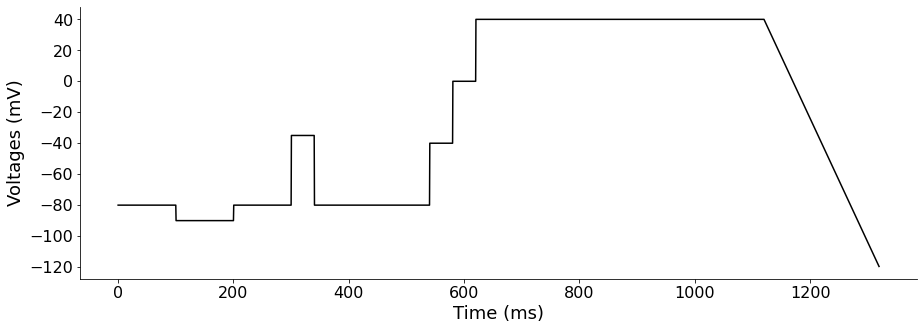

In [7]:
times = np.arange(0, VC_protocol.get_voltage_change_endpoints()[-1], 0.5) 
VC_protocol.plot_voltage_clamp_protocol(times)

In [8]:
cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}

# t_eval = np.linspace(0, end_time, 10000)  

In [9]:
start_time = time.time()

model, p, s = myokit.load("../mmt-model-files/ohara-cipa-v1-2017_JK-v2.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=vhold)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ohara2017"  

f = 1.5
params = {         
    'cell.mode': cell_types['Mid-myocardial'],
    'setting.simType': 1,   # 0: AP   |  1: VC  
    
    'ina.gNa' : 75.0 * f,   
    'inal.gNaL' : 0.0199575 * f,  # 0.0075 * 2.661 * f,  
    'ito.gto' : 0.08 * f, # 0.02 * 4 * f,
    'ical.PCa' : 0.00025175 * f, # 0.0001 * 1.007 * 2.5 * f,
    'ikr.gKr' : 0.06056109090909093 * f,  #  4.65854545454545618e-2 * 1.3 * f, # [mS/uF]
    'iks.gKs' : 0.0089012 * f, # 0.0034 * 1.87 * 1.4 * f,
    'ik1.gK1' : 0.42117192000000003 * f, # 0.1908 * 1.698 * 1.3 * f,
    'inaca.gNaCa' : 0.0008 * 1.4,
    'inak.PNaK' : 30 * 0.7,
    'ikb.gKb' : 0.003,
    'inab.PNab' : 3.75e-10,
    'icab.PCab' : 2.5e-8,
    'ipca.GpCa' : 0.0005,
}
sim.set_simulation_params(params)

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.773407459259033 seconds ---


In [10]:
end_time = VC_protocol.get_voltage_change_endpoints()[-1]

window = 10
step_size = 10

extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL_total', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa']

In [11]:
start_time = time.time()

params = {         
    'ina.g_adj' : 1,  
    'inal.g_adj' : 1,
    'ito.g_adj' : 1,
    'ical.g_adj' : 1,
    'ikr.g_adj' : 1,
    'iks.g_adj' : 1,
    'ik1.g_adj' : 1,
    'inaca.g_adj' : 1,
    'inak.g_adj' : 1,
    'ikb.g_adj' : 1,
    'inab.g_adj' : 1,
    'icab.g_adj' : 1,
    'ipca.g_adj' : 1, 
}
sim.set_simulation_params(params)

y0 = sim.pre_simulate(5000, sim_type=1)
d = sim.simulate(end_time, log_times=None, extra_log=['membrane.i_ion'] + extra_log)

sol1 = {}
times1 = d['engine.time']
sol1["Voltage"] = VC_protocol.get_voltage_clamp_protocol(d['engine.time'])
sol1["I_total"] = d['membrane.i_ion']
sol1["window"] = get_currents_with_constant_dt([ d['engine.time'], d['membrane.i_ion'] ], window=window, step_size=step_size)
sol1["INa"] = d['ina.INa']
sol1["INaL"] = d['inal.INaL']
sol1["Ito"] = d['ito.Ito']
sol1["ICaL"] = d['ical.ICaL_total']
sol1["IKr"] = d['ikr.IKr']
sol1["IKs"] = d['iks.IKs']
sol1["IK1"] = d['ik1.IK1']

tr = mod_trace.Trace(VC_protocol,
                     cell_params=None,
                     t=times1,
                     y=sol1["Voltage"],  # simulator.model.V,
                     command_voltages=sol1["Voltage"],
                     current_response_info=sim.current_response_info,
                     default_unit=None)   
max_contributions1 = tr.current_response_info.get_max_current_contributions(time=times1,
                                                                           window=window,
                                                                           step_size=step_size)

print(len(sol1["window"]))

print("--- %s seconds ---"%(time.time()-start_time))

132
--- 0.38308262825012207 seconds ---


In [12]:
max_contributions1

,Current,Contribution,Time Start,Time End
0,i_ion,0.000000,0.0,10.0
1,INa,0.399851,540.0,550.0
2,INaL,0.409170,320.0,330.0
3,Ito,0.159657,630.0,640.0
4,ICaL_total,0.495971,1150.0,1160.0
5,IKr,0.367760,1200.0,1210.0
6,IKs,0.208155,1110.0,1120.0
7,IK1,0.496402,1310.0,1320.0
8,INaCa,0.021317,560.0,570.0
9,INaCa_ss,0.005191,560.0,570.0


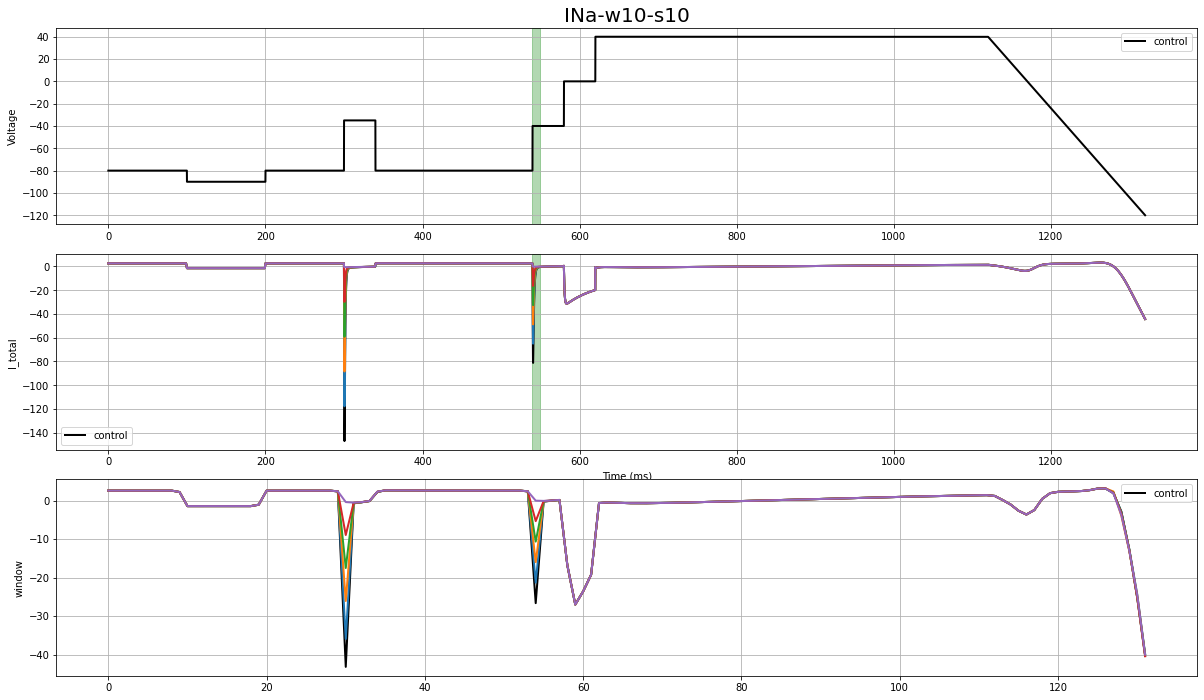

In [13]:
plot_li = ["I_total", "window" ]
check_current = "INa"
nShow = 5
dy = 1.0/(nShow)


fig, ax = plt.subplots(3,1, figsize=(18,10))    
ax[0].set_title(f'{check_current}-w{window}-s{step_size}', fontsize=20)
for i, name in enumerate( ["Voltage"] + plot_li ):    
    ax[i].set_ylabel(f'{name}')  
    if name=='window':
        ax[i].plot( sol1[name], label='control', color='k', linewidth=2)     
    else:
        ax[i].plot( times1, sol1[name], label='control', color='k', linewidth=2)         
    
        contribution = max_contributions1[max_contributions1["Current"]==check_current]['Contribution'].values[0]
        start = max_contributions1[max_contributions1["Current"]==check_current]['Time Start'].values[0]
        end = max_contributions1[max_contributions1["Current"]==check_current]['Time End'].values[0]         
        ax[i].axvspan(start, end, color='g', alpha=0.3)  
        
    ax[i].legend()
    ax[i].grid()


for j in range(1, nShow+1):
        
    # g_adj = random.random()
    # if i==0: g_adj = 1.0
    
    params = {         
        'cell.mode': cell_types['Mid-myocardial'],
        'setting.simType': 1,   # 0: AP   |  1: VC  

        'ina.g_adj' : 1 - dy*j,  
        'inal.g_adj' : 1,
        'ito.g_adj' : 1 ,
        'ical.g_adj' : 1 ,
        'ikr.g_adj' : 1,
        'iks.g_adj' : 1,
        'ik1.g_adj' : 1,
        'inaca.g_adj' : 1,
        'inak.g_adj' : 1,
        'ikb.g_adj' : 1,
        'inab.g_adj' : 1 ,
        'icab.g_adj' : 1 ,
        'ipca.g_adj' : 1 , 
    }
    sim.set_simulation_params(params)

    # sim.set_initial_values([-88] + y0)
    sim.pre_simulate(5000, sim_type=1)
    d = sim.simulate(end_time, log_times=None , extra_log=['membrane.VC', 'membrane.i_ion'] + extra_log)
    
    sol2 = {}
    times2 = d['engine.time']
    sol2["Voltage"] = d['membrane.VC']
    sol2["I_total"] = d['membrane.i_ion']
    sol2["window"] = get_currents_with_constant_dt([ d['engine.time'], d['membrane.i_ion'] ], window=window, step_size=step_size)
    # sol2["INa"] = sim.current_response_info.get_current(['INa'])
    # sol2["INaL"] = sim.current_response_info.get_current(['INaL'])
    # sol2["Ito"] = sim.current_response_info.get_current(['Ito'])
    # sol2["ICaL"] = sim.current_response_info.get_current(['ICaL'])
    # sol2["IKr"] = sim.current_response_info.get_current(['IKr'])
    # sol2["IKs"] = sim.current_response_info.get_current(['IKs'])
    # sol2["IK1"] = sim.current_response_info.get_current(['IK1'])
    
    tr = mod_trace.Trace(VC_protocol,
                         cell_params=None,
                         t=times2,
                         y=sol2["Voltage"],  # simulator.model.V,
                         command_voltages=sol2["Voltage"],
                         current_response_info=sim.current_response_info,
                         default_unit=None)   
    max_contributions2 = tr.current_response_info.get_max_current_contributions(time=times2,
                                                                               window=window,
                                                                               step_size=step_size)
    
    
    '''
    Plot
    '''
    # current_name = 'IKr'
    
    # fig.suptitle(sim.name, fontsize=14)
    for i, name in enumerate(plot_li):            
        # ax.set_title('Simulation %d'%(simulationNo))
        # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())            
        # ax[i].plot( times1, sol1[name], label='control', color='k', linewidth=5)     
        if name=='window':            
            # ax[i].set_xlabel('Time (ms)')                   
            ax[i+1].plot( sol2[name], label='treatment', linewidth=2)    
        else:            
            ax[i+1].set_xlabel('Time (ms)')       
            ax[i+1].plot( times2, sol2[name], label='treatment', linewidth=2)    

        # if i!=0 and i!=1:
        #     contribution = max_contributions1[max_contributions1["Current"]==name]['Contribution'].values[0]
        #     start = max_contributions1[max_contributions1["Current"]==name]['Time Start'].values[0]
        #     end = max_contributions1[max_contributions1["Current"]==name]['Time End'].values[0]         
        #     ax[i].axvspan(start, end, color='g', alpha=0.3)  

    # ax[-1].set_ylim(-5, 5)

y_min = -50
y_max = 5
# ax[1].set_ylim(y_min, y_max)        
# ax[2].set_ylim(y_min, y_max)            

fig.savefig(os.path.join(result_dir, f"{check_current}_w{window}_s{step_size}.jpg"), dpi=100)
plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()